In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
#from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
#import plotly.express as px
import random
#from keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import seaborn as sns
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
#from keras import Layers
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras import layers
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

2024-12-08 21:37:34.243101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 21:37:34.284361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 21:37:34.296695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 21:37:34.492853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


I0000 00:00:1733690257.588618   31118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733690258.002651   31118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733690258.002737   31118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def fetch_image(data_folder):
    train_data = []
    test_data = []
    valid_data = []

    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }

    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")

        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue

            # Load and preprocess the image
            imgTrafficSignal = Image.open(image_path)
            #imgTrafficSignal = imgTrafficSignal.convert("L")  # Convert to grayscale
            img_width, img_height = imgTrafficSignal.size

            with open(label_path, "r") as label_file:
                label_lines = label_file.readlines()
                for line in label_lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert normalized bounding box to pixel coordinates
                    x_center_pixel = int(x_center * img_width)
                    y_center_pixel = int(y_center * img_height)
                    width_pixel = int(width * img_width)
                    height_pixel = int(height * img_height)

                    # Calculate the bounding box corners
                    x1 = max(x_center_pixel - width_pixel // 2, 0)
                    y1 = max(y_center_pixel - height_pixel // 2, 0)
                    x2 = min(x_center_pixel + width_pixel // 2, img_width)
                    y2 = min(y_center_pixel + height_pixel // 2, img_height)

                    # Crop the sign area from the image
                    cropped_img = imgTrafficSignal.crop((x1, y1, x2, y2))
                    cropped_img = cropped_img.resize((90, 90))  # Resize to 90x90

                    # Append the cropped image and class ID to the appropriate dataset
                    if split_name == "train":
                        train_data.append((np.array(cropped_img), class_id))
                    elif split_name == "test":
                        test_data.append((np.array(cropped_img), class_id))
                    elif split_name == "valid":
                        valid_data.append((np.array(cropped_img), class_id))

    return train_data, test_data, valid_data

In [4]:
# Example usage
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image(data_folder)

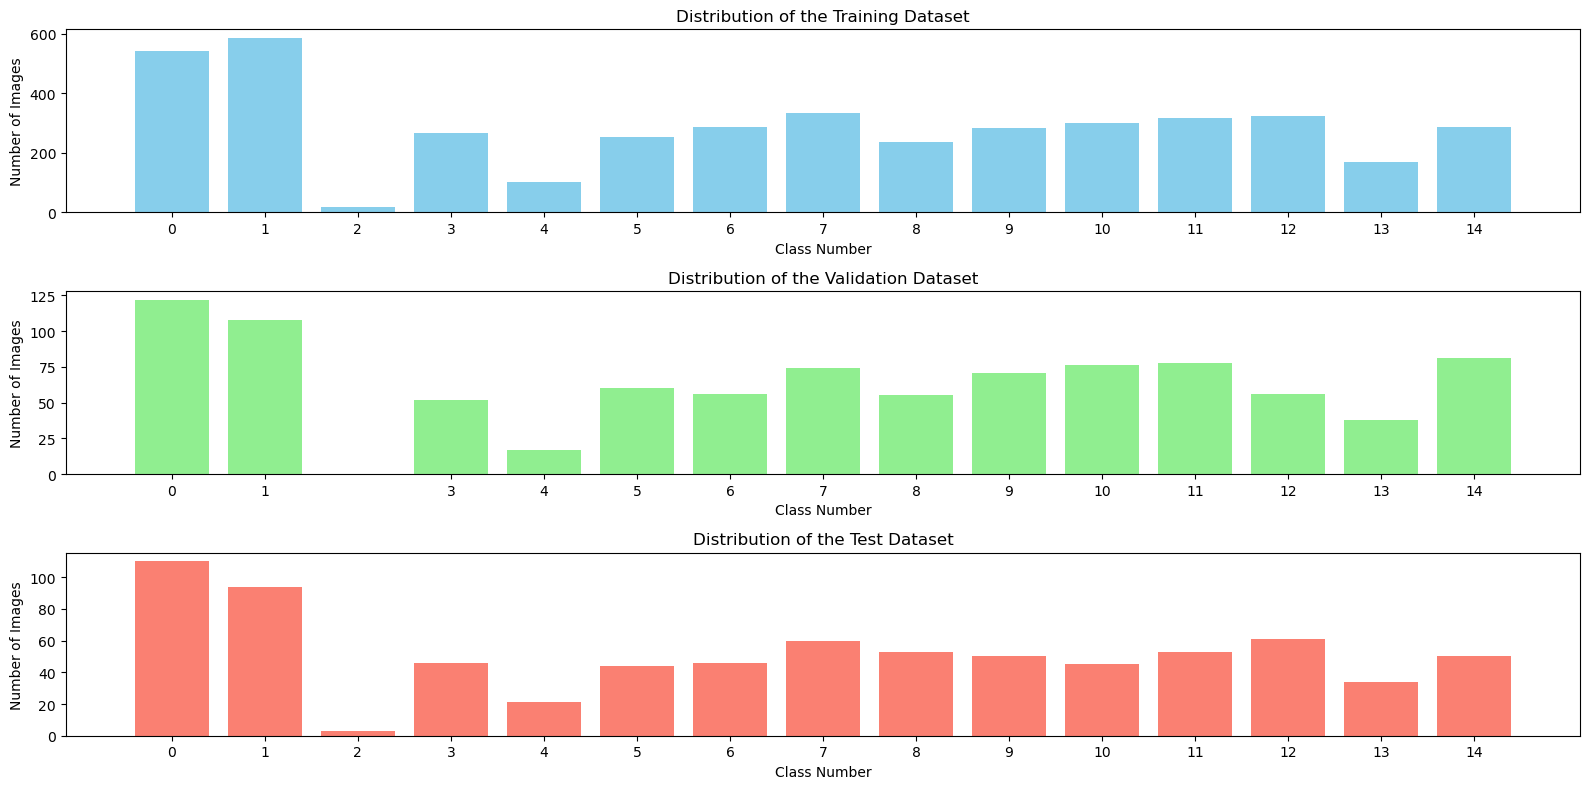

In [5]:
# Count the number of samples per class in each dataset
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

# Sort the counts for consistent visualization
train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

# Plot the distributions for all splits
plt.figure(figsize=(16, 8))

# Training Dataset
plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

# Validation Dataset
plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

# Test Dataset
plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

# Show the combined plot
plt.tight_layout()
plt.show()


In [6]:
print("Training Dataset Class Distribution:", train_class_counts)
print("Validation Dataset Class Distribution:", valid_class_counts)
print("Test Dataset Class Distribution:", test_class_counts)


Training Dataset Class Distribution: Counter({1: 585, 0: 542, 7: 334, 12: 323, 11: 318, 10: 301, 6: 285, 14: 285, 9: 283, 3: 267, 5: 252, 8: 235, 13: 168, 4: 101, 2: 19})
Validation Dataset Class Distribution: Counter({0: 122, 1: 108, 14: 81, 11: 78, 10: 76, 7: 74, 9: 71, 5: 60, 6: 56, 12: 56, 8: 55, 3: 52, 13: 38, 4: 17})
Test Dataset Class Distribution: Counter({0: 110, 1: 94, 12: 61, 7: 60, 11: 53, 8: 53, 9: 50, 14: 50, 6: 46, 3: 46, 10: 45, 5: 44, 13: 34, 4: 21, 2: 3})


In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract training labels and class indices
training_labels = []
for class_id, count in Counter({1: 585, 0: 542, 7: 334, 12: 323, 11: 318, 10: 301, 6: 285, 
                                 14: 285, 9: 283, 3: 267, 5: 252, 8: 235, 13: 168, 4: 101, 2: 19}).items():
    training_labels.extend([class_id] * count)

# Calculate class weights
classes = np.unique(training_labels)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=training_labels)

# Convert to a dictionary for Keras
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.5286592865928659, 1: 0.4898005698005698, 2: 15.080701754385965, 3: 1.0731585518102371, 4: 2.836963696369637, 5: 1.137037037037037, 6: 1.0053801169590644, 7: 0.8578842315369262, 8: 1.219290780141844, 9: 1.012485276796231, 10: 0.951937984496124, 11: 0.9010482180293501, 12: 0.8871001031991744, 13: 1.7055555555555555, 14: 1.0053801169590644}


In [10]:
# Global variable to store augmentations
STORED_AUGMENTATIONS = []

def shear_image(image, shear_level=0.2):
    """
    Apply a shear transformation to the image.
    Args:
        image (tf.Tensor): Input image
        shear_level (float): Shearing intensity
    Returns:
        tf.Tensor: Sheared image
    """
    # Define affine transformation matrix for shearing
    shear_matrix = tf.convert_to_tensor([
        [1.0, shear_level, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ])
    # Apply affine transformation
    image_shape = tf.shape(image)
    sheared_image = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, axis=0),
        transforms=tf.linalg.inv(shear_matrix)[0:2, :],  # Extract top two rows for transformation
        output_shape=image_shape[:2],
        interpolation="BILINEAR"
    )
    return tf.squeeze(sheared_image, axis=0)
    
def augmentation_pipeline(image):
    """
    Apply multiple augmentation techniques.
    Args:
        image (np.ndarray): Input image
    Returns:
        np.ndarray: Augmented image
    """
    img_tensor = tf.convert_to_tensor(image)
    
    # Random rotation
    rotation_k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    rotated = tf.image.rot90(img_tensor, k=rotation_k)
    
    # Random horizontal flip
    flipped = tf.image.random_flip_left_right(rotated)
    
    # Random brightness
    brightness_img = tf.image.random_brightness(flipped, max_delta=0.2)
    
    # Random contrast
    contrast_img = tf.image.random_contrast(brightness_img, lower=0.8, upper=1.2)

    # Apply shearing
    shear_level = tf.random.uniform([], -0.3, 0.3)  # Random shear between -0.3 and 0.3
    sheared_img = shear_image(contrast_img, shear_level)
    
    # Add random noise
    noise = tf.random.normal(shape=tf.shape(sheared_img), mean=0.0, stddev=0.05)
    noisy_img = tf.clip_by_value(sheared_img + noise, 0.0, 1.0)
    
    return noisy_img.numpy()

def augment_data(train_data, augmentation_factor=3, input_shape=(90, 90, 3), max_stored_augmentations=10):
    """
    Augment data and store a limited number of augmentations globally.
    Args:
        train_data (list): List of (image, label) tuples
        augmentation_factor (int): Number of augmented versions per original image
        input_shape (tuple): Shape of input images
        max_stored_augmentations (int): Maximum number of augmentations to store globally
    Returns:
        list: Augmented dataset
    """
    global STORED_AUGMENTATIONS
    STORED_AUGMENTATIONS = []  # Reset stored augmentations

    train_features, train_labels = zip(*train_data)
    train_features = np.array(train_features, dtype=np.float32) / 255.0
    train_features = train_features.reshape(-1, *input_shape)
    train_labels = np.array(train_labels)

    augmented_features = []
    augmented_labels = []
    stored_count = 0

    for i in range(len(train_features)):
        original_img = train_features[i]
        label = train_labels[i]
        augmented_images = [original_img]  # Store the original image

        # Add the original image to the dataset
        augmented_features.append(original_img)
        augmented_labels.append(label)

        for _ in range(augmentation_factor):
            try:
                augmented_img = augmentation_pipeline(original_img)
                augmented_features.append(augmented_img)
                augmented_labels.append(label)

                if stored_count < max_stored_augmentations:
                    augmented_images.append(augmented_img)
            except Exception as e:
                print(f"Augmentation error for image {i}: {e}")

        # Store the augmentations globally
        if stored_count < max_stored_augmentations:
            STORED_AUGMENTATIONS.append((original_img, augmented_images))
            stored_count += 1

    augmented_dataset = list(zip(augmented_features, augmented_labels))
    indices = np.random.permutation(len(augmented_dataset))
    augmented_dataset = [augmented_dataset[i] for i in indices]
    
    return augmented_dataset

def visualize_stored_augmentations():
    """
    Visualize stored augmentations.
    """
    global STORED_AUGMENTATIONS

    num_images = len(STORED_AUGMENTATIONS)
    if num_images == 0:
        print("No augmentations stored.")
        return

    fig, axes = plt.subplots(num_images, len(STORED_AUGMENTATIONS[0][1]), figsize=(15, 3*num_images))

    for i, (original, augmented_versions) in enumerate(STORED_AUGMENTATIONS):
        for j, img in enumerate(augmented_versions):
            if num_images == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            ax.imshow(img if j == 0 else img)
            ax.axis('off')
            ax.set_title("Original" if j == 0 else f"Augmented {j}")

    plt.tight_layout()
    plt.show()


In [11]:

# Apply augmentation to your training data
augmented_train_data = augment_data(train_data)


I0000 00:00:1733690331.396532   31118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733690331.396713   31118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733690331.396776   31118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733690331.943084   31118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733690331.943270   31118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08

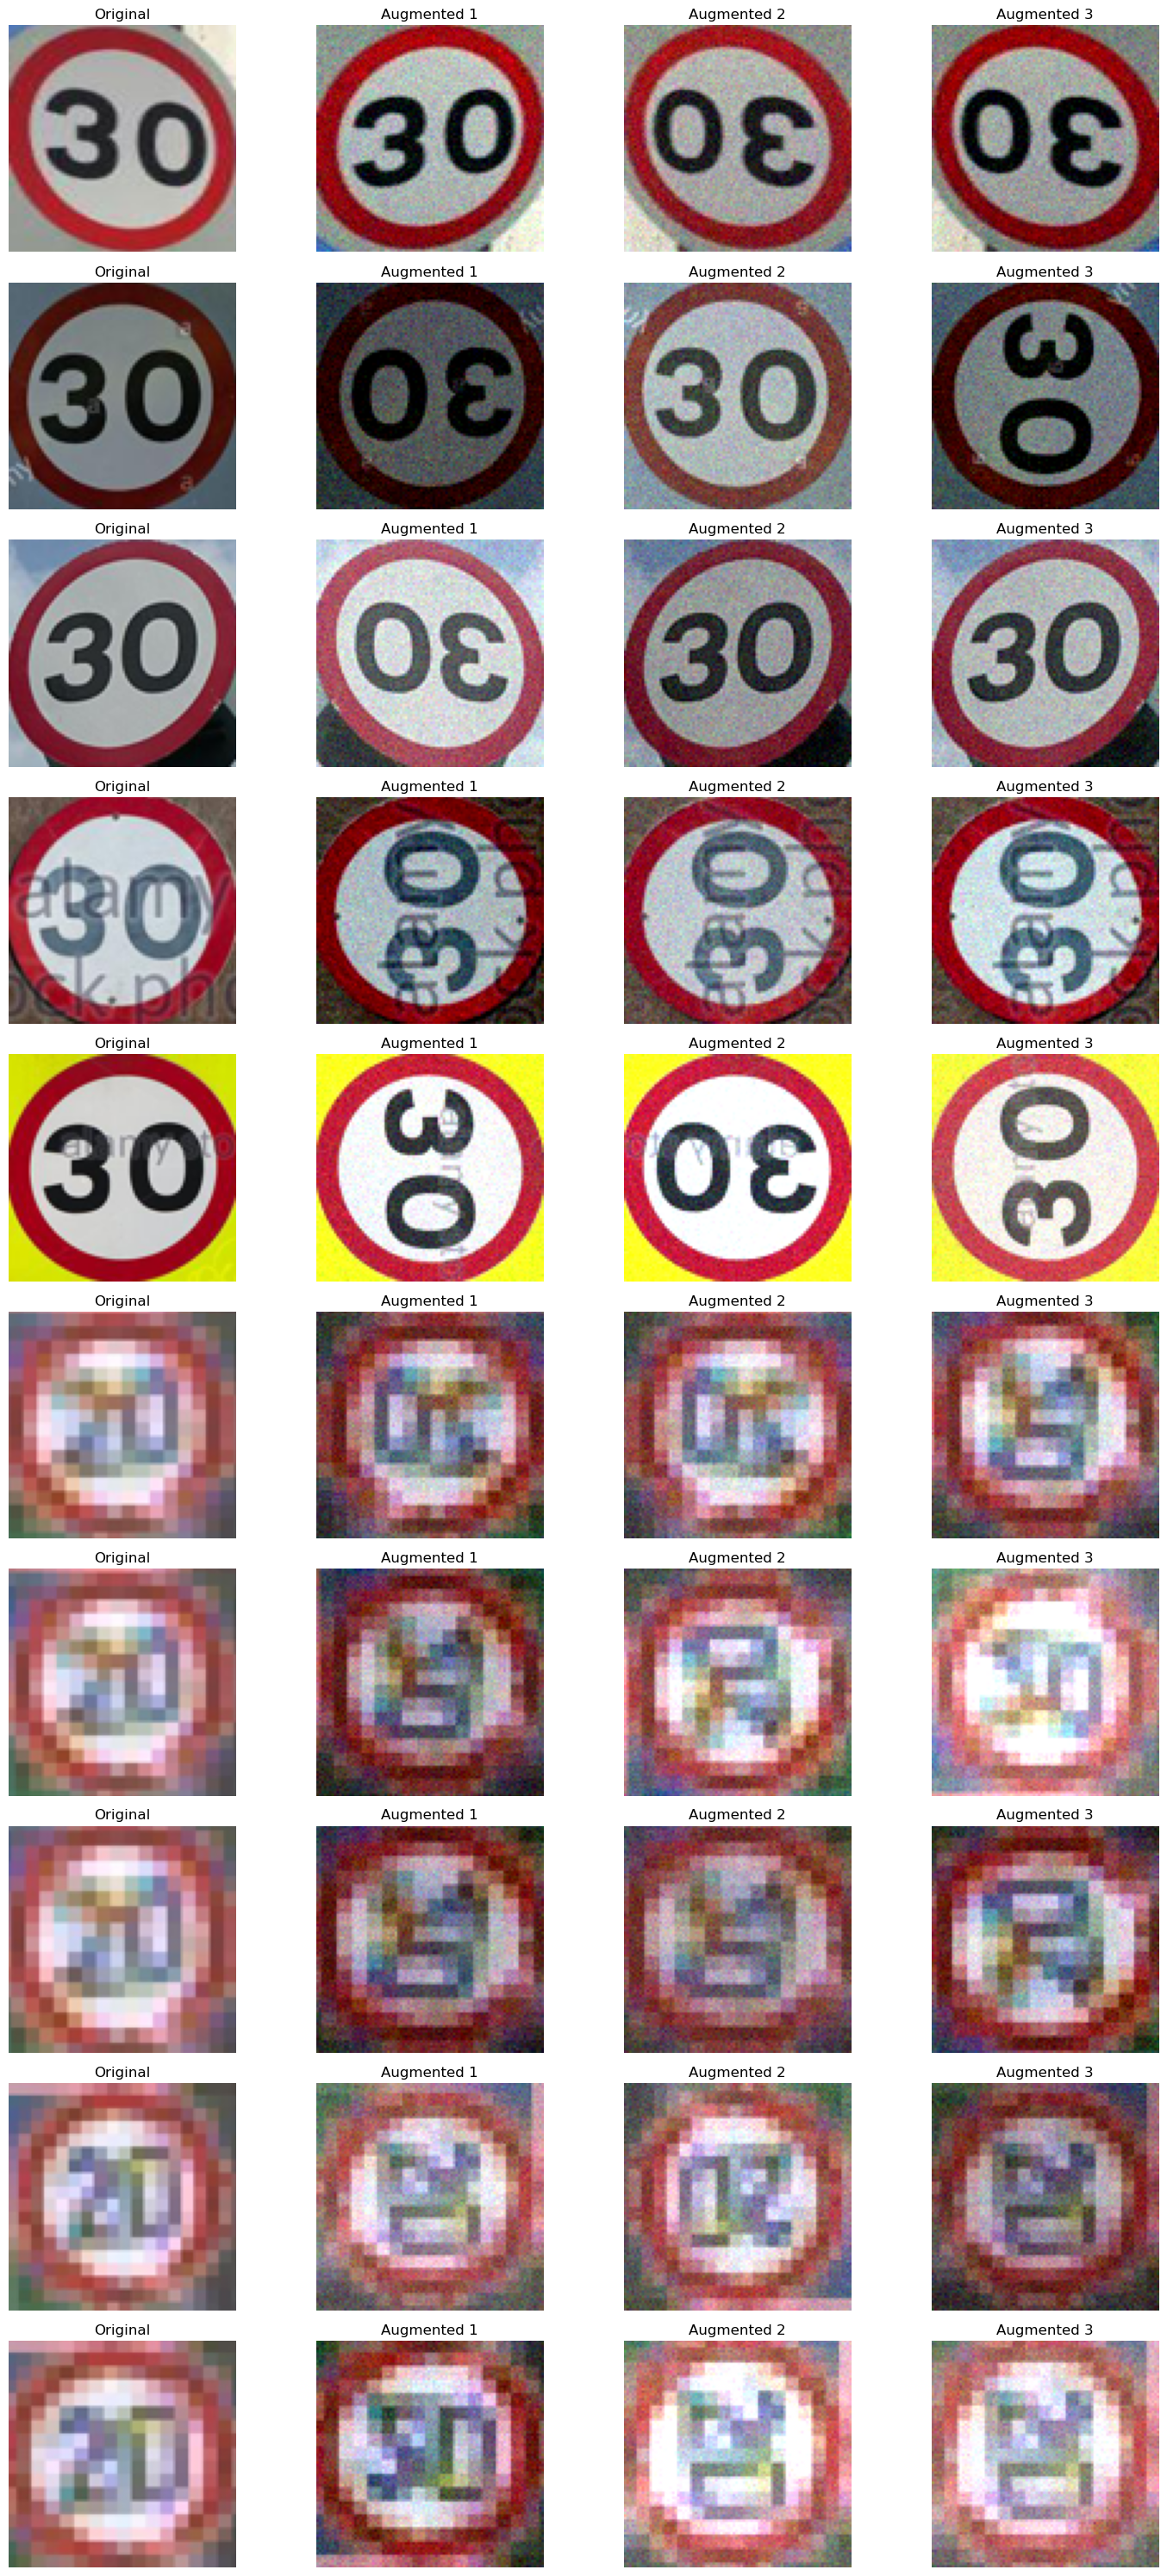

In [12]:
visualize_stored_augmentations()



In [13]:
# Prepare augmented training data
training_data_features, training_data_labels = zip(*augmented_train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)
training_data_features = training_data_features.reshape(-1, 90, 90, 3)

In [14]:
# Verify normalization
print("Feature range:", training_data_features.min(), training_data_features.max())
print("Number of augmented samples:", len(training_data_features))

Feature range: 0.0 1.0
Number of augmented samples: 17192


In [15]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)


training_data_features = training_data_features.astype(np.float32) / 255.0

# Reshape for CNN (add channel dimension)
training_data_features = training_data_features.reshape(-1, 90, 90, 3)

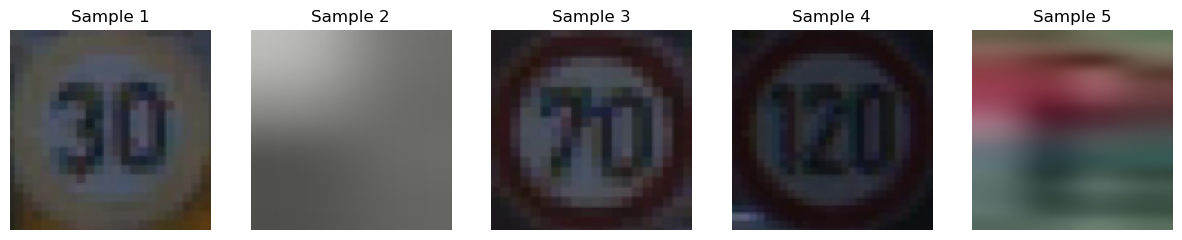

In [16]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    random_idx = random.randint(0, len(training_data_features) - 1)
    img = training_data_features[random_idx]

    # Ensure proper scaling to 0-255
    img = (img * 255).astype(np.uint8)

    axs[i].imshow(img, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Sample {i+1}")

plt.show()


In [17]:
training_data_labels

array([ 7,  7,  7, ..., 14, 14, 14])

In [29]:
# Define the data augmentation pipeline
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])


cnnModel = keras.Sequential()

# Convolutional Block 1
#cnnModel.add(data_augmentation)  # Add the augmentation layer here

cnnModel.add(Conv2D(32, (5,5), padding="same", input_shape=(90, 90, 3), activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
#cnnModel.add(Dropout(0.2))  # Dropout after the first pooling layer

# Convolutional Block 2
cnnModel.add(Conv2D(64, (5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.15))  # Dropout after the second pooling layer

# Convolutional Block 3
cnnModel.add(Conv2D(128, (3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.2))  # Dropout after third pooling layer

# Convolutional Block 4
cnnModel.add(Conv2D(256, (3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.3))  # Dropout after the fourth pooling layer

# Fully Connected (Dense) Layers
cnnModel.add(Flatten())
cnnModel.add(Dense(512, activation='relu'))
cnnModel.add(Dropout(0.25))  # Dropout after Dense layer to reduce overfitting
cnnModel.add(Dense(15, activation='softmax'))

/home/user/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cnnModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
from keras.optimizers import Adam

cnnModel.compile(optimizer=Adam(learning_rate=0.0001), 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])


In [31]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training if no improvement for 3 consecutive epochs
    restore_best_weights=True  # Restore the best model weights after stopping
)
# Define the ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=2,          # After 2 epochs of no improvement
    min_lr=1e-6          # Set a lower bound for the learning rate
)
tensorboard_callback = TensorBoard(log_dir='./logs')


In [32]:
# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)

# Normalize validation images
validation_data_features = validation_data_features / 255.0
validation_data_features = validation_data_features.reshape(-1, 90, 90, 3)

In [33]:


# Train the model
trafficSignNetwork = cnnModel.fit(
    training_data_features, 
    training_data_labels, 
    validation_data=(validation_data_features, validation_data_labels),
    epochs=60, 
    batch_size=32,
    class_weight=class_weight_dict,  # Add the class weights here
    callbacks=[early_stopping, lr_scheduler, tensorboard_callback]  # Include the callbacks
)

Epoch 1/60


I0000 00:00:1733690843.291921   31196 service.cc:146] XLA service 0x7fdf70001790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733690843.291961   31196 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-12-08 21:47:23.362773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  5/135 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0589 - loss: 2.2562

I0000 00:00:1733690847.504366   31196 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1145 - loss: 2.6230

2024-12-08 21:47:34.441389: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 4 bytes spill stores, 4 bytes spill loads



135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.1150 - loss: 2.6226 - val_accuracy: 0.3305 - val_loss: 2.0318 - learning_rate: 1.0000e-04
Epoch 2/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3253 - loss: 2.2698 - val_accuracy: 0.4121 - val_loss: 1.8278 - learning_rate: 1.0000e-04
Epoch 3/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3637 - loss: 2.0507 - val_accuracy: 0.4566 - val_loss: 1.6706 - learning_rate: 1.0000e-04
Epoch 4/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4509 - loss: 1.8049 - val_accuracy: 0.5233 - val_loss: 1.5626 - learning_rate: 1.0000e-04
Epoch 5/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5119 - loss: 1.5823 - val_accuracy: 0.7161 - val_loss: 1.0322 - learning_rate: 1.0000e-04
Epoch 6/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6740 - loss: 1.1232 - val_accuracy: 0.7934 - val_loss: 0.7252 - learning_rate: 1.0000e-04
Epoch 7/60
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7

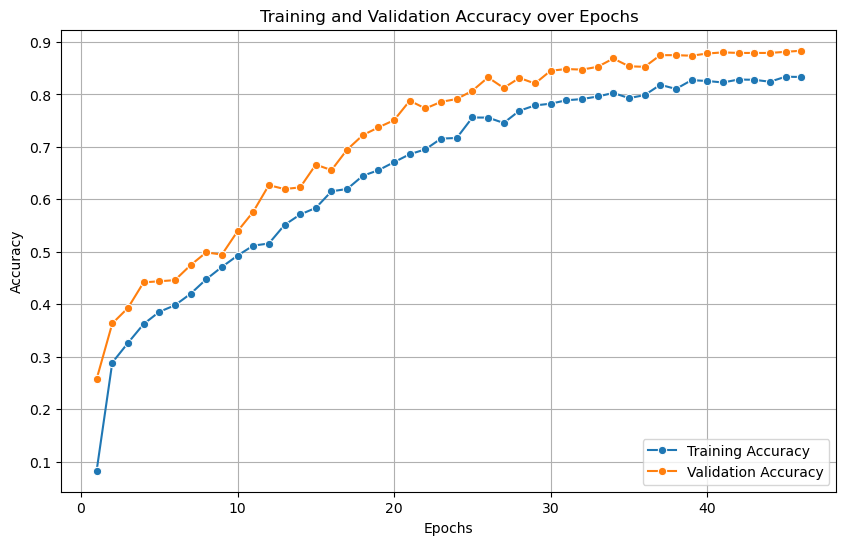

In [24]:
import seaborn as sns
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['accuracy']) + 1)),
             y=trafficSignNetwork.history['accuracy'],
             marker='o', label='Training Accuracy')

sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['val_accuracy']) + 1)),
             y=trafficSignNetwork.history['val_accuracy'],
             marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [25]:
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features)
test_data_labels = np.array(test_data_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


W0000 00:00:1733690646.362490   31200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733690646.363764   31200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733690646.365608   31200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733690646.366871   31200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733690646.367872   31200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733690646.368781   31200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733690646.369675   31200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733690646.370583   31200 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1733690646.372134   31200 gp

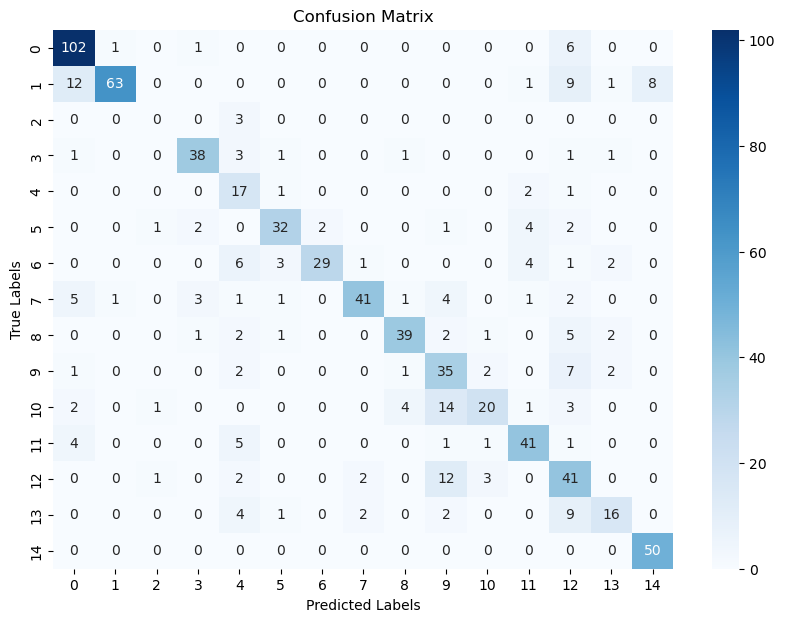

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       110
           1       0.97      0.67      0.79        94
           2       0.00      0.00      0.00         3
           3       0.84      0.83      0.84        46
           4       0.38      0.81      0.52        21
           5       0.80      0.73      0.76        44
           6       0.94      0.63      0.75        46
           7       0.89      0.68      0.77        60
           8       0.85      0.74      0.79        53
           9       0.49      0.70      0.58        50
          10       0.74      0.44      0.56        45
          11       0.76      0.77      0.77        53
          12       0.47      0.67      0.55        61
          13       0.67      0.47      0.55        34
          14       0.86      1.00      0.93        50

    accuracy                           0.73       770
   macro avg       0.70      0.67      0.67       770
weighted avg       0.77   

In [28]:
cnnModel.save("models/model_v5.keras")
